**IMPORTING LIBRARIES**

In [ ]:
!pip install Augmentor
import Augmentor 
import os, glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt


**MOUNTING DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def unzipping_dataset():
  !unzip 'gdrive/My Drive/dataset/trainingbenign.zip'
  !unzip 'gdrive/My Drive/dataset/trainingmalign.zip'
  !unzip 'gdrive/My Drive/dataset/testbenign.zip'
  !unzip 'gdrive/My Drive/dataset/testmalign.zip'

**UNZIPPING DATASET** 

In [ ]:
unzipping_dataset()

Archive:  gdrive/My Drive/dataset/trainingbenign.zip
  inflating: trainingbenign/us1.bmp  
  inflating: trainingbenign/us11.bmp  
  inflating: trainingbenign/us12.bmp  
  inflating: trainingbenign/us13.bmp  
  inflating: trainingbenign/us14.bmp  
  inflating: trainingbenign/us16.bmp  
  inflating: trainingbenign/us17.bmp  
  inflating: trainingbenign/us18.bmp  
  inflating: trainingbenign/us19.bmp  
  inflating: trainingbenign/us2.bmp  
  inflating: trainingbenign/us21.bmp  
  inflating: trainingbenign/us22.bmp  
  inflating: trainingbenign/us23.bmp  
  inflating: trainingbenign/us24.bmp  
  inflating: trainingbenign/us26.bmp  
  inflating: trainingbenign/us27.bmp  
  inflating: trainingbenign/us28.bmp  
  inflating: trainingbenign/us29.bmp  
  inflating: trainingbenign/us3.bmp  
  inflating: trainingbenign/us31.bmp  
  inflating: trainingbenign/us32.bmp  
  inflating: trainingbenign/us33.bmp  
  inflating: trainingbenign/us34.bmp  
  inflating: trainingbenign/us36.bmp  
  inflating: t

**DATA** **AUGMENTATION**

In [ ]:
# By default these will be written to the disk in a directory named 
# output relative to the path specified when initialising the p pipeline object above.

def augmenting_benign(path):
  p = Augmentor.Pipeline(path) 
  p.flip_left_right(0.5) 
  #p.black_and_white(0.1) 
  p.rotate(0.3, 10, 10) 
  p.skew(0.4, 0.5) 
  p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5) 
  p.sample(500) 

def augmenting_malignant(path):
  p = Augmentor.Pipeline(path) 
  p.flip_left_right(0.5) 
  #p.black_and_white(0.1) 
  p.rotate(0.3, 10, 10) 
  p.skew(0.4, 0.5) 
  p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5) 
  p.sample(750) 

In [ ]:
augmenting_benign ('trainingbenign')
augmenting_malignant ('trainingmalign')

Processing <PIL.Image.Image image mode=L size=143x75 at 0x7F4C29F80CF8>:   5%|▍         | 23/500 [00:00<00:04, 107.07 Samples/s]                 

Initialised with 80 image(s) found.
Output directory set to trainingbenign/output.

Processing <PIL.BmpImagePlugin.BmpImageFile image mode=L size=105x79 at 0x7F4C2473D6D8>: 100%|██████████| 500/500 [00:01<00:00, 376.42 Samples/s]
Processing <PIL.Image.Image image mode=L size=137x113 at 0x7F4C24736A20>:   1%|          | 6/750 [00:00<01:18,  9.42 Samples/s]                

Initialised with 120 image(s) found.
Output directory set to trainingmalign/output.

Processing <PIL.Image.Image image mode=L size=191x77 at 0x7F4C245D49E8>: 100%|██████████| 750/750 [00:02<00:00, 345.44 Samples/s]


**FORMING TRAINING DATA**

In [ ]:
def enumerating (path):
  images=[]
  filelist = sorted(glob.glob(os.path.join(path, '*.bmp')))
  for j, imagepath in enumerate(filelist):
    img1 = cv2.imread(filelist[j])
    img1 = cv2.resize(img1, (44, 44), interpolation=cv2.INTER_LINEAR)
    images.append(img1)
  return images

def form_training_data (b_path, b_path_aug, m_path, m_path_aug):
  images=[]
  imgs = enumerating (b_path)
  images.extend (imgs)
  imgs = enumerating (b_path_aug)
  images.extend (imgs)
  print (len(images))
  imgs = enumerating (m_path)
  images.extend (imgs)
  imgs = enumerating (m_path_aug)
  images.extend (imgs)
  print (len(images))
  return images

In [ ]:
images = form_training_data ('trainingbenign','trainingbenign/output','trainingmalign','trainingmalign/output')
images = np.stack (images,axis = 0)

580
1450


In [ ]:
images.shape

(1450, 44, 44, 3)

In [ ]:
print (len(images))

1450


**LABEL TO THE TRAINING IMAGES**

In [ ]:
labels = []
for i in range (len(images)):
  if (i<580):
    labels.append (0)     #0 label for benign lesions
  else:
    labels.append (1)     #1 label for malignant lesions

import numpy as np
labels = np.reshape (np.stack(labels, axis = 0), (1450,1))

In [ ]:
labels.shape

(1450, 1)

**TRAIN-TEST DATA SPLITTING**

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42) 

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images, val_images = train_images / 255.0, val_images / 255.0

**CREATING MODEL**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Convolution2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(44,44,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64, (3, 3), padding ='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.25))
  model.add(Convolution2D(128, (3, 3),padding = 'same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(64, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 44, 44, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 5, 128)        

**COMPILING MODEL**

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = "gdrive/My Drive/classification_model/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels),callbacks=[cp_callback])

Epoch 1/20
30/37 [=======================>......] - ETA: 0s - loss: 0.6799 - accuracy: 0.5813
Epoch 00001: saving model to gdrive/My Drive/classification_model/model.ckpt
37/37 [==============================] - 0s 9ms/step - loss: 0.6724 - accuracy: 0.5853 - val_loss: 0.6150 - val_accuracy: 0.7345
Epoch 2/20
30/37 [=======================>......] - ETA: 0s - loss: 0.5501 - accuracy: 0.7354
Epoch 00002: saving model to gdrive/My Drive/classification_model/model.ckpt
37/37 [==============================] - 0s 7ms/step - loss: 0.5231 - accuracy: 0.7500 - val_loss: 0.4051 - val_accuracy: 0.8310
Epoch 3/20
30/37 [=======================>......] - ETA: 0s - loss: 0.3722 - accuracy: 0.8344
Epoch 00003: saving model to gdrive/My Drive/classification_model/model.ckpt
37/37 [==============================] - 0s 6ms/step - loss: 0.3636 - accuracy: 0.8371 - val_loss: 0.3260 - val_accuracy: 0.8552
Epoch 4/20
29/37 [======================>.......] - ETA: 0s - loss: 0.3185 - accuracy: 0.8599
Epoch 

**PLOTTING HISTORY**

In [ ]:
def plot(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')

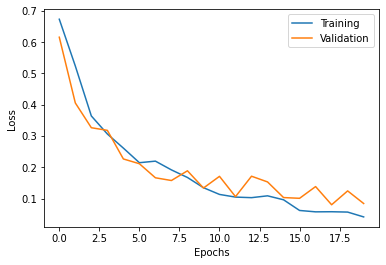

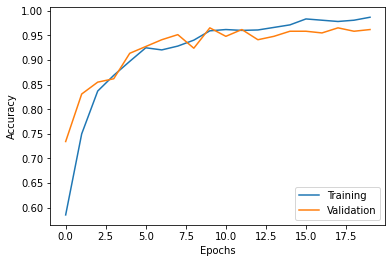

In [ ]:
plot (history)

**LOADING SAVED MODEL**

In [ ]:
model = create_model ()
checkpoint_path = "gdrive/My Drive/classification_model/model.ckpt"
model.load_weights(checkpoint_path)

**PREDICTION ON TEST IMAGES**

In [ ]:
def pred (image):
  data = []
  data.append(image)
  X_test = np.array(data)
  X_test = X_test.astype('float32')/255 
  pred = model.predict_classes(X_test)
  return pred[0]  

In [ ]:
## PREDICTION ON TEST BENIGN

filelist = sorted(glob.glob(os.path.join('testbenign', '*.bmp')))
t_benign = []
for j, imagepath in enumerate(filelist):
  img1 = cv2.imread(filelist[j])
  img1 = cv2.resize(img1, (44, 44), interpolation=cv2.INTER_LINEAR)
  label = pred (np.array (img1))
  t_benign.append (label)

In [ ]:
print (t_benign)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
## PREDICTION ON TEST MALIGNANT

filelist = sorted(glob.glob(os.path.join('testmalign', '*.bmp')))
t_malignant = []
for j, imagepath in enumerate(filelist):
  img1 = cv2.imread(filelist[j])
  img1 = cv2.resize(img1, (44, 44), interpolation=cv2.INTER_LINEAR)
  label = pred (np.array (img1))
  t_malignant.append (label)

In [ ]:
print (t_malignant)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**RED ATTACK**